<a href="https://colab.research.google.com/github/rpdahxn/HandsOnML/blob/main/17_autoencoders_and_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version은 코랩에서만 동작합니다.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
def plot_image(image):
  plt.imshow(image, cmap = 'binary')
  plt.axis('off')

## 17.2 과소완전 선형 오토인코더로 PCA 수행하기

3D 데이터셋을 만든다.

In [ ]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

오토인코더를 만든다.

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential(keras.layers.Dense(2, input_shape = [3]))
decoder = keras.models.Sequential(keras.layers.Dense(3, input_shape = [2]))

autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss = 'mse', optimizer = keras.optimizers.SGD(learning_rate = 1.5))

In [ ]:
history = autoencoder.fit(X_train, X_train, epochs = 20)

Epoch 1/20
2/2 [==============================] - 0s 10ms/step - loss: 0.1576
Epoch 2/20
2/2 [==============================] - 0s 10ms/step - loss: 0.0698
Epoch 3/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0808
Epoch 4/20
2/2 [==============================] - 0s 9ms/step - loss: 0.1614
Epoch 5/20
2/2 [==============================] - 0s 8ms/step - loss: 0.1213
Epoch 6/20
2/2 [==============================] - 0s 8ms/step - loss: 0.0409
Epoch 7/20
2/2 [==============================] - 0s 11ms/step - loss: 0.0279
Epoch 8/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0206
Epoch 9/20
2/2 [==============================] - 0s 9ms/step - loss: 0.0137
Epoch 10/20
2/2 [==============================] - 0s 10ms/step - loss: 0.0103
Epoch 11/20
2/2 [==============================] - 0s 10ms/step - loss: 0.0087
Epoch 12/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0072
Epoch 13/20
2/2 [==============================] - 0s 7ms/step - los

In [ ]:
codings = autoencoder.predict(X_train)

오토인코더는 데이터에 있는 분산이 가능한 많이 보존되도록 데이터를 투영할 최상의 2D 평면을 찾는다.

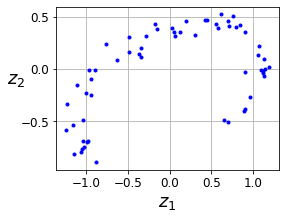

In [ ]:
fig = plt.figure(figsize = (4, 3))
plt.plot(codings[:, 0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize = 18)
plt.ylabel("$z_2$", fontsize = 18, rotation = 0)
plt.grid(True)
plt.show()

## 17.3 적층 오토인코더

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

X_train, X_valid = X_train[:-5000], X_train[-5000:]
y_train, y_test = y_train[:-5000], y_train[-5000:]

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 13s 5ms/step - loss: 0.3381 - rounded_accuracy: 0.8870 - val_loss: 0.3170 - val_rounded_accuracy: 0.8996
Epoch 2/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3056 - rounded_accuracy: 0.9152 - val_loss: 0.3021 - val_rounded_accuracy: 0.9199
Epoch 3/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2986 - rounded_accuracy: 0.9215 - val_loss: 0.2985 - val_rounded_accuracy: 0.9199
Epoch 4/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2948 - rounded_accuracy: 0.9249 - val_loss: 0.2938 - val_rounded_accuracy: 0.9285
Epoch 5/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.2920 - val_rounded_accuracy: 0.9285
Epoch 6/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2904 - rounded_accuracy: 0.9289 - val_loss: 0.2914 - val_rounded_accuracy: 0.9305
Epoch 7/20
1719/1719 [=================

## 17.10 연습문제  
9. 잡음 제거 오토인코더를 사용해 이미지 분류기를 사전훈련해보세요.  
- 데이터셋을 훈련 세트와 테스트 세트로 나눕니다. 전체 훈련 세트에서 심층 잡음 제거 오토인코더를 훈련합니다.  
잡음은 입력에 추가된 순수한 가우시안 잡음이거나 드롭아웃처럼 무작위로 입력을 꺼서 발생시킬 수도 있다.  
1. 드롭아웃 사용

In [5]:
from tensorflow import keras

In [3]:
from keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

X_train, X_valid = X_train[:-5000], X_train[-5000:]
y_train, y_test = y_train[:-5000], y_train[-5000:]

4431872/4422102 [==============================] - 0s 0us/step


In [6]:
dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dropout(0.5),  # 픽셀의 절반을 끈다.
    keras.layers.Dense(100, activation = 'selu'),
    keras.layers.Dense(30, activation = 'selu')
])

dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation = 'selu', input_shape = [30]),
    keras.layers.Dense(28 * 28, activation= 'sigmoid'),
    keras.layers.Reshape([28, 28])
])

dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])

In [8]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [11]:
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 4ms/step - loss: 0.3565 - rounded_accuracy: 0.8709 - val_loss: 0.3203 - val_rounded_accuracy: 0.9041
Epoch 2/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3181 - rounded_accuracy: 0.9035 - val_loss: 0.3110 - val_rounded_accuracy: 0.9116
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3121 - rounded_accuracy: 0.9081 - val_loss: 0.3063 - val_rounded_accuracy: 0.9153
Epoch 4/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3086 - rounded_accuracy: 0.9108 - val_loss: 0.3034 - val_rounded_accuracy: 0.9185
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3062 - rounded_accuracy: 0.9128 - val_loss: 0.3011 - val_rounded_accuracy: 0.9199
Epoch 6/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3043 - rounded_accuracy: 0.9144 - val_loss: 0.3004 - val_rounded_accuracy: 0.9187
Epoch 7/10
1719/1719 [=================

In [12]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [14]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

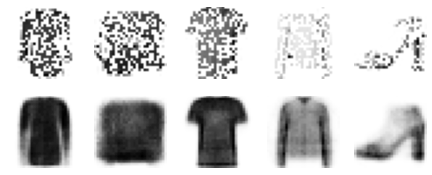

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))

2. 가우시안 잡음 사용  
fashion_mnist

In [16]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 4ms/step - loss: 0.3500 - rounded_accuracy: 0.8773 - val_loss: 0.3166 - val_rounded_accuracy: 0.9078
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3120 - rounded_accuracy: 0.9097 - val_loss: 0.3089 - val_rounded_accuracy: 0.9153
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3060 - rounded_accuracy: 0.9148 - val_loss: 0.3033 - val_rounded_accuracy: 0.9179
Epoch 4/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3025 - rounded_accuracy: 0.9179 - val_loss: 0.2999 - val_rounded_accuracy: 0.9218
Epoch 5/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2996 - rounded_accuracy: 0.9205 - val_loss: 0.2973 - val_rounded_accuracy: 0.9238
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2974 - rounded_accuracy: 0.9223 - val_loss: 0.2959 - val_rounded_accuracy: 0.9267
Epoch 7/10
1719/1719 [==================

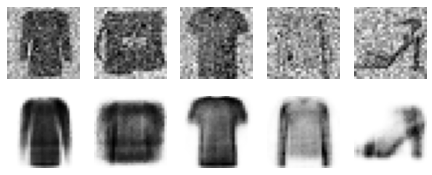

In [17]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

cifar10

In [18]:
[X_train, y_train], [X_test, y_test] = keras.datasets.cifar10.load_data()
X_train = X_train / 255
X_test = X_test / 255

170508288/170498071 [==============================] - 11s 0us/step


In [19]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.GaussianNoise(0.1, input_shape=[32, 32, 3]),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"),
])

In [20]:
denoising_encoder.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise_2 (GaussianN  (None, 32, 32, 3)        0         
 oise)                                                           
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               4194816   
                                                                 
Total params: 4,195,712
Trainable params: 4,195,712
No

In [21]:
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(16 * 16 * 32, activation="relu", input_shape=[512]),
    keras.layers.Reshape([16, 16, 32]),
    keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2,
                                 padding="same", activation="sigmoid")
])

In [22]:
denoising_decoder.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 8192)              4202496   
                                                                 
 reshape_2 (Reshape)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 3)        867       
 nspose)                                                         
                                                                 
Total params: 4,203,363
Trainable params: 4,203,363
Non-trainable params: 0
_________________________________________________________________


In [23]:
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Nadam(),
                     metrics=["mse"])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_test, X_test))

Epoch 1/10
1563/1563 [==============================] - 40s 20ms/step - loss: 0.5929 - mse: 0.0184 - val_loss: 0.5989 - val_mse: 0.0197
Epoch 2/10
1563/1563 [==============================] - 31s 20ms/step - loss: 0.5724 - mse: 0.0099 - val_loss: 0.5747 - val_mse: 0.0103
Epoch 3/10
1563/1563 [==============================] - 30s 19ms/step - loss: 0.5673 - mse: 0.0079 - val_loss: 0.5720 - val_mse: 0.0093
Epoch 4/10
1563/1563 [==============================] - 31s 20ms/step - loss: 0.5651 - mse: 0.0071 - val_loss: 0.5715 - val_mse: 0.0091
Epoch 5/10
1563/1563 [==============================] - 30s 19ms/step - loss: 0.5639 - mse: 0.0066 - val_loss: 0.5681 - val_mse: 0.0077
Epoch 6/10
1563/1563 [==============================] - 30s 19ms/step - loss: 0.5630 - mse: 0.0063 - val_loss: 0.5666 - val_mse: 0.0071
Epoch 7/10
1563/1563 [==============================] - 30s 19ms/step - loss: 0.5623 - mse: 0.0060 - val_loss: 0.5659 - val_mse: 0.0068
Epoch 8/10
1563/1563 [==========================

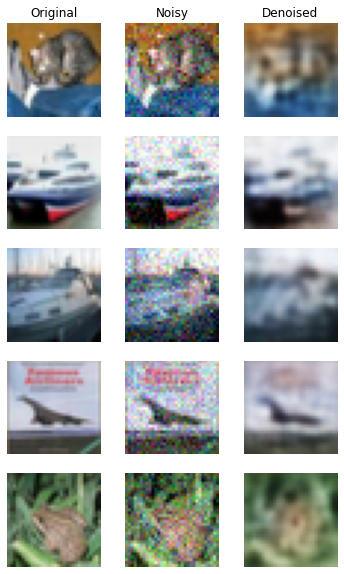

In [24]:
n_images = 5
new_images = X_test[:n_images]
new_images_noisy = new_images + np.random.randn(n_images, 32, 32, 3) * 0.1
new_images_denoised = denoising_ae.predict(new_images_noisy)

plt.figure(figsize=(6, n_images * 2))
for index in range(n_images):
    plt.subplot(n_images, 3, index * 3 + 1)
    plt.imshow(new_images[index])
    plt.axis('off')
    if index == 0:
        plt.title("Original")
    plt.subplot(n_images, 3, index * 3 + 2)
    plt.imshow(np.clip(new_images_noisy[index], 0., 1.))
    plt.axis('off')
    if index == 0:
        plt.title("Noisy")
    plt.subplot(n_images, 3, index * 3 + 3)
    plt.imshow(new_images_denoised[index])
    plt.axis('off')
    if index == 0:
        plt.title("Denoised")
plt.show()

10. 이미지 데이터셋을 하나 선택해 변이형 오토인코더를 훈련하고 이미지를 생성해보세요.  
fashion_mnist 

In [31]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

X_train, X_valid = X_train[:-5000], X_train[-5000:]
y_train, y_test = y_train[:-5000], y_train[-5000:]

In [28]:
K = keras.backend

In [29]:
class Sampling(keras.layers.Layer):  # 평균과 표준편차가 주어졌을 때 코딩을 샘플링하는 사용자 정의 층
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [32]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)  # 배치에있는 모든 샘플의 평균 손실을 계산하고 재구성 손실에 비례해 적절한 크기가 되도록 784로 나눈다.
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 5s 9ms/step - loss: 0.3895 - rounded_accuracy: 0.8611 - val_loss: 0.3563 - val_rounded_accuracy: 0.8899
Epoch 2/25
430/430 [==============================] - 3s 8ms/step - loss: 0.3424 - rounded_accuracy: 0.8981 - val_loss: 0.3393 - val_rounded_accuracy: 0.9046
Epoch 3/25
430/430 [==============================] - 3s 8ms/step - loss: 0.3326 - rounded_accuracy: 0.9056 - val_loss: 0.3330 - val_rounded_accuracy: 0.9085
Epoch 4/25
430/430 [==============================] - 3s 8ms/step - loss: 0.3277 - rounded_accuracy: 0.9092 - val_loss: 0.3296 - val_rounded_accuracy: 0.9115
Epoch 5/25
430/430 [==============================] - 3s 8ms/step - loss: 0.3247 - rounded_accuracy: 0.9120 - val_loss: 0.3263 - val_rounded_accuracy: 0.9151
Epoch 6/25
430/430 [==============================] - 3s 8ms/step - loss: 0.3224 - rounded_accuracy: 0.9138 - val_loss: 0.3250 - val_rounded_accuracy: 0.9108
Epoch 7/25
430/430 [==============================] 

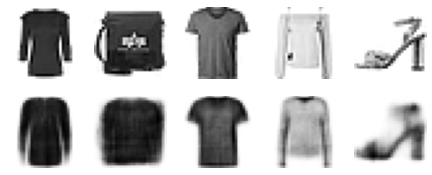

In [33]:
show_reconstructions(variational_ae)
plt.show()

11. 이미지 데이터셋을 처리하는 DCGAN을 훈련하고 이를 사용해 이미지를 생성해보세요.  
fashion mnist

In [35]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

X_train, X_valid = X_train[:-5000], X_train[-5000:]
y_train, y_test = y_train[:-5000], y_train[-5000:]

In [36]:
X_train.shape

(55000, 28, 28)

In [37]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [38]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [40]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

In [41]:
X_train_dcgan.shape

(55000, 28, 28, 1)

In [42]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [45]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [46]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()    

Epoch 1/50


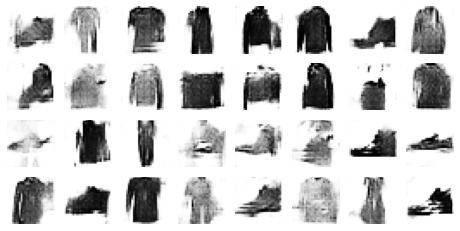

Epoch 2/50


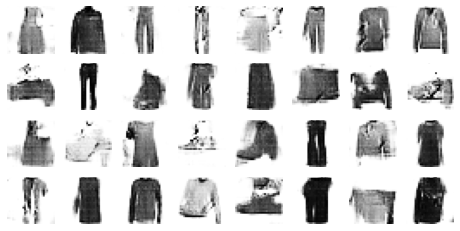

Epoch 3/50


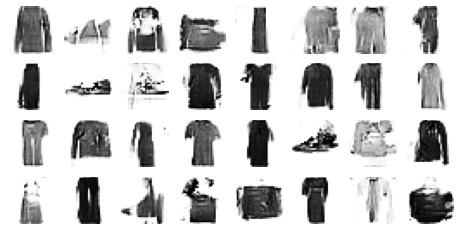

Epoch 4/50


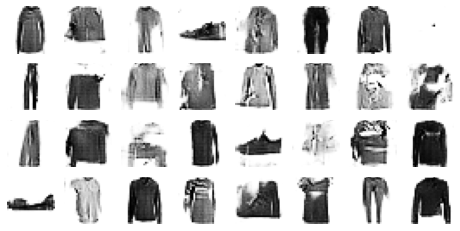

Epoch 5/50


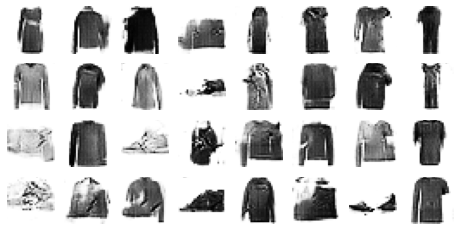

Epoch 6/50


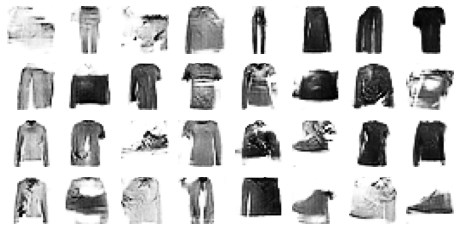

Epoch 7/50


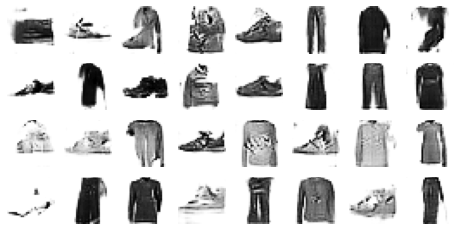

Epoch 8/50


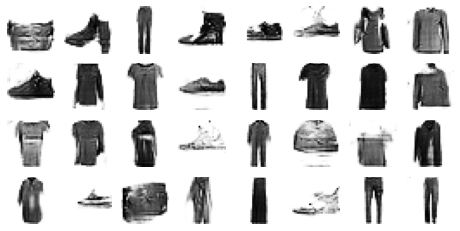

Epoch 9/50


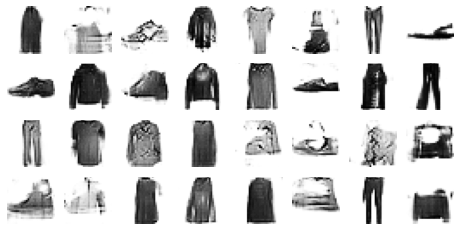

Epoch 10/50


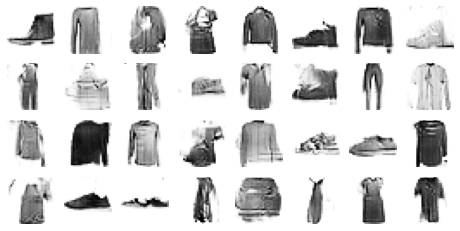

Epoch 11/50


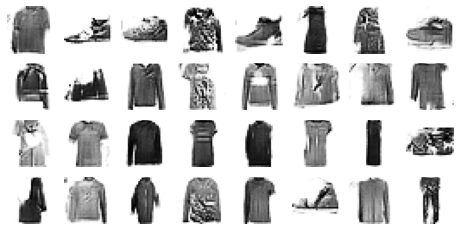

Epoch 12/50


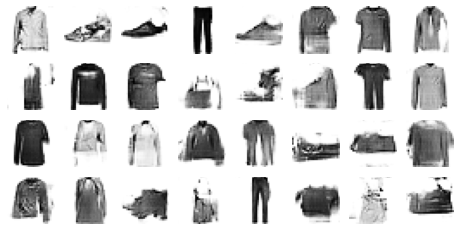

Epoch 13/50


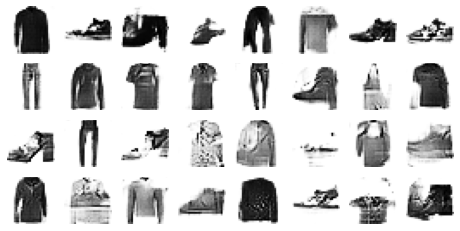

Epoch 14/50


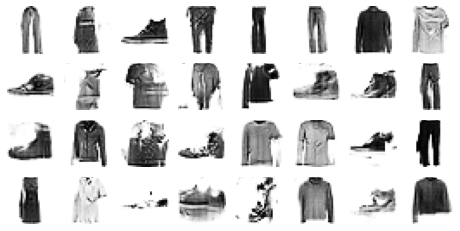

Epoch 15/50


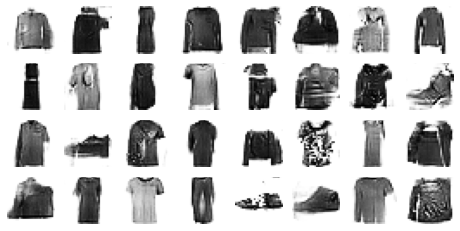

Epoch 16/50


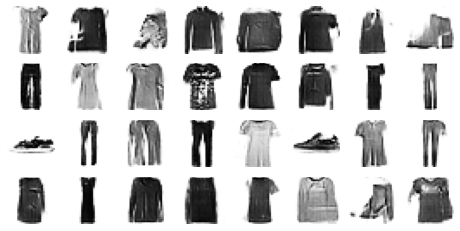

Epoch 17/50


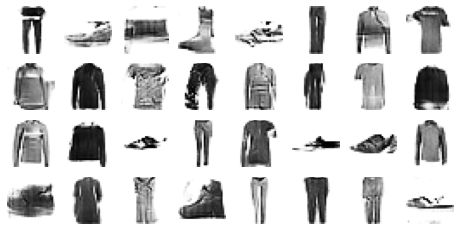

Epoch 18/50


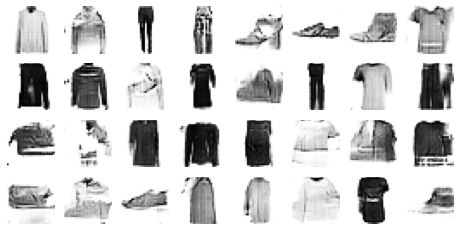

Epoch 19/50


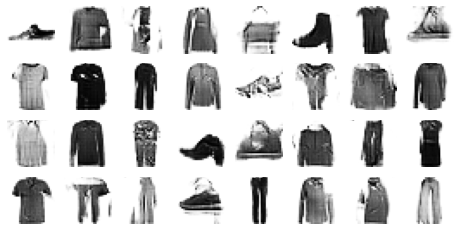

Epoch 20/50


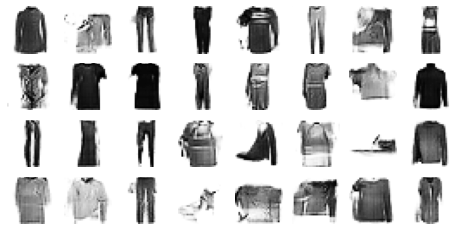

Epoch 21/50


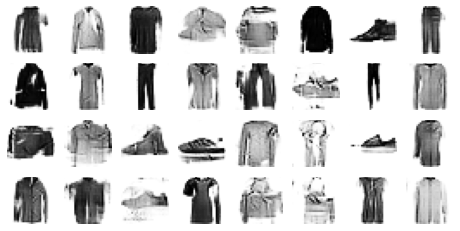

Epoch 22/50


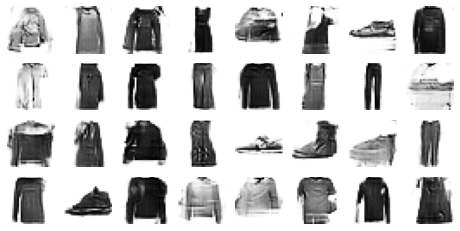

Epoch 23/50


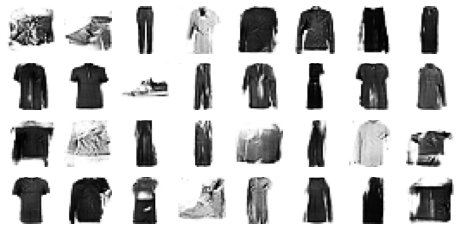

Epoch 24/50


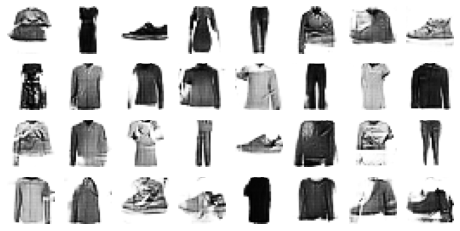

Epoch 25/50


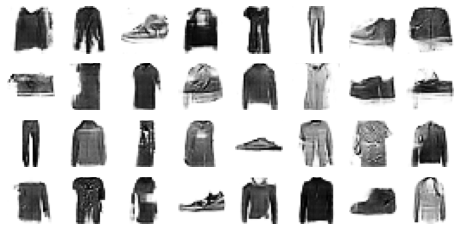

Epoch 26/50


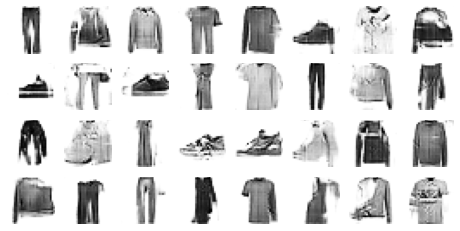

Epoch 27/50


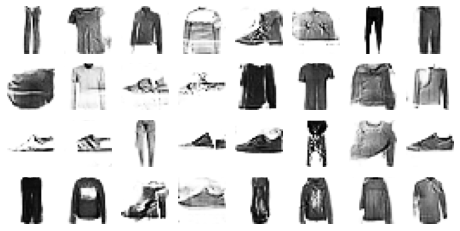

Epoch 28/50


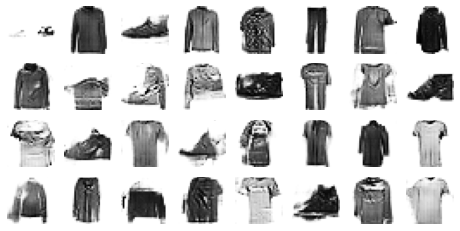

Epoch 29/50


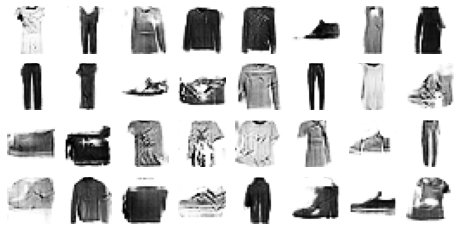

Epoch 30/50


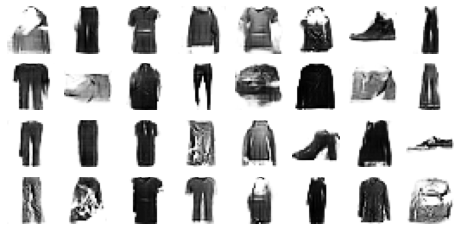

Epoch 31/50


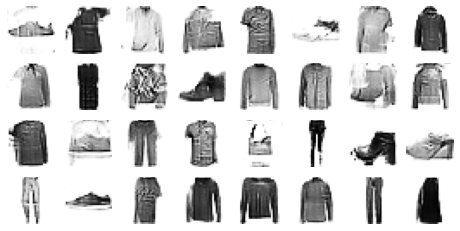

Epoch 32/50


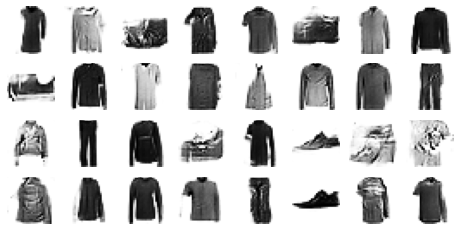

Epoch 33/50


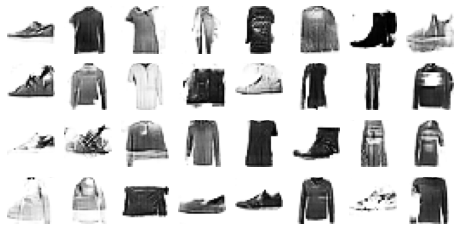

Epoch 34/50


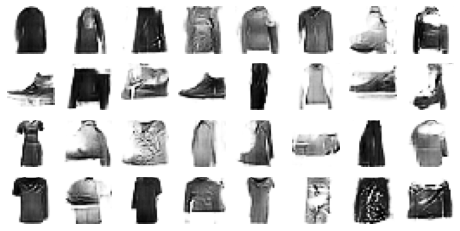

Epoch 35/50


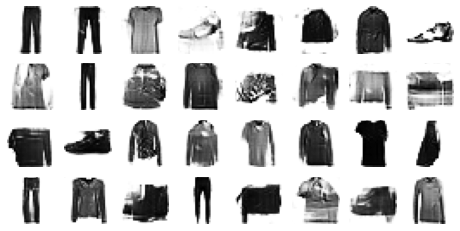

Epoch 36/50


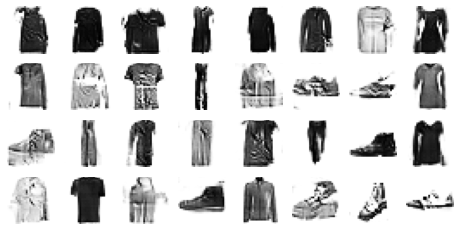

Epoch 37/50


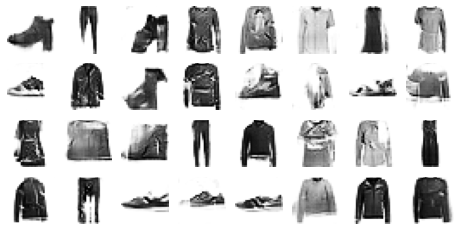

Epoch 38/50


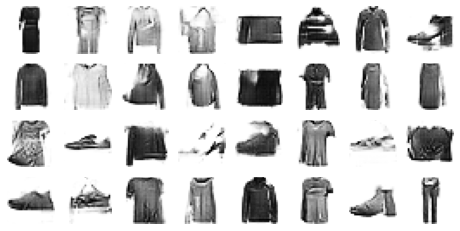

Epoch 39/50


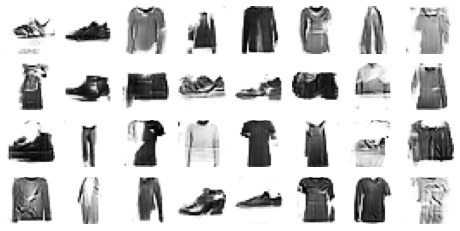

Epoch 40/50


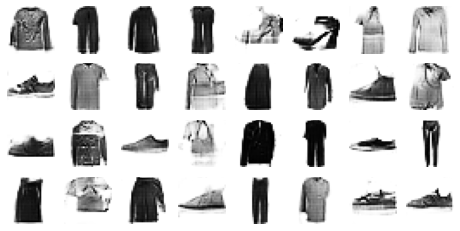

Epoch 41/50


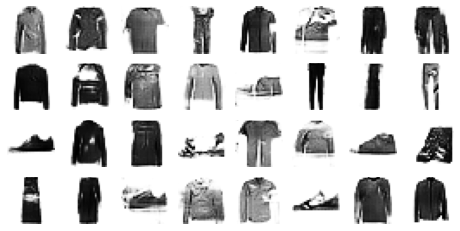

Epoch 42/50


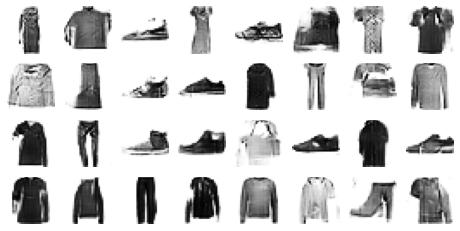

Epoch 43/50


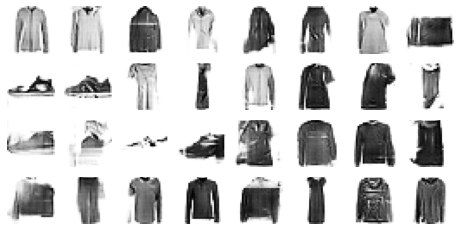

Epoch 44/50


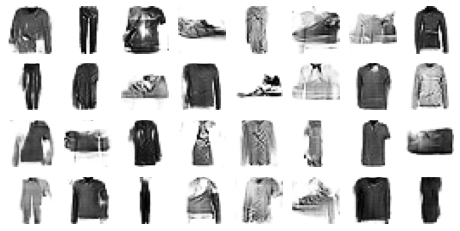

Epoch 45/50


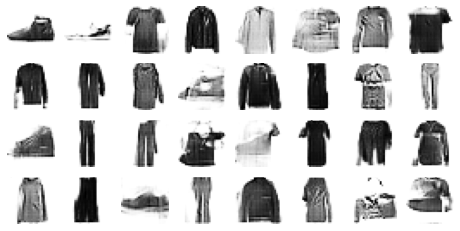

Epoch 46/50


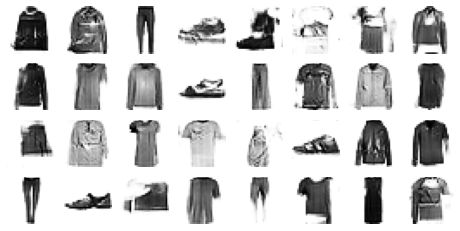

Epoch 47/50


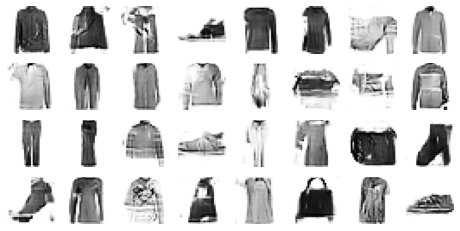

Epoch 48/50


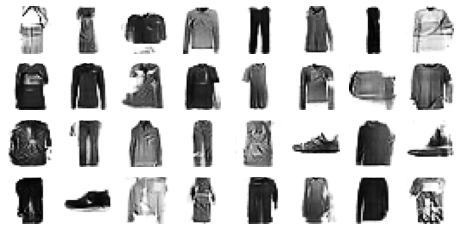

Epoch 49/50


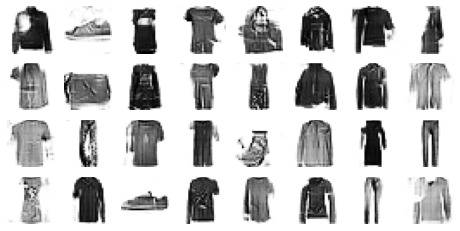

Epoch 50/50


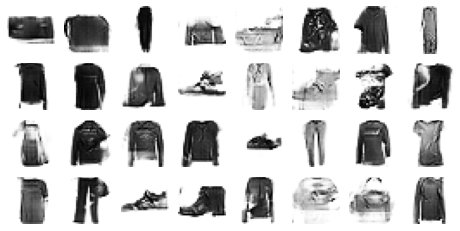

In [47]:
train_gan(gan, dataset, batch_size, codings_size)